## Imports


In [1]:
from numpy import pi

import qutip as qt

from rich import print as pprint

import matplotlib
from matplotlib import colors, cm, patches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

from trical.light_matter import *
from trical.backend.qutip.base import QutipBackend

In [2]:
matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

muted_palette = sns.color_palette("muted", n_colors=10, desat=0.8)

## Atomic Circuit


In [3]:
downstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=0,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 0,
)
upstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 10,
)
estate = Level(
    principal=5,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=-1,
    energy=2 * np.pi * 100,
)
estate2 = Level(
    principal=5,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=1,
    energy=2 * np.pi * 110,
)

transitions = [
    Transition(
        level1=downstate,
        level2=estate,
        einsteinA=1,
        multipole="E1",
    ),
    Transition(
        level1=downstate,
        level2=estate2,
        einsteinA=1,
        multipole="E1",
    ),
    Transition(
        level1=upstate,
        level2=estate,
        einsteinA=1,
        multipole="E1",
    ),
    Transition(
        level1=upstate,
        level2=estate2,
        einsteinA=1,
        multipole="E1",
    ),
]

Yb171 = Ion(
    mass=1,
    charge=1,
    position=[0, 0, 0],
    levels=[downstate, upstate, estate, estate2],
    transitions=transitions,
)

COM_x = Phonon(energy=2 * np.pi * 0.1, eigenvector=[1, 0, 0])

system = System(
    ions=[
        Yb171,
    ],
    modes=[
        COM_x,
    ],
)

beam = Beam(
    transition=transitions[0],
    rabi=2 * np.pi * 1,
    detuning=COM_x.energy,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=0,
)
beam2 = Beam(
    transition=transitions[0],
    rabi=2 * np.pi * 1,
    detuning=-COM_x.energy,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=0,
)


protocol = ParallelProtocol(
    sequence=[
        # Pulse(beam=beam, duration=10),
        Pulse(beam=beam2, duration=10),
    ]
)

circuit = AtomicCircuit(system=system, protocol=protocol)

## Qutip Intepreter


In [4]:
backend = QutipBackend()

fock_cutoff = 10
experiment, hilbert_space, fock_cutoff = backend.compile(circuit, fock_cutoff)

In [5]:
%timeit experiment.base(0)
%timeit experiment.sequence[0].hamiltonian(0)

533 μs ± 1.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
9.69 ms ± 788 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Results


In [6]:
result = backend.run(
    experiment,
    hilbert_space=[10, "f"],
    fock_cutoff=fock_cutoff,
    timestep=1e-2,
)

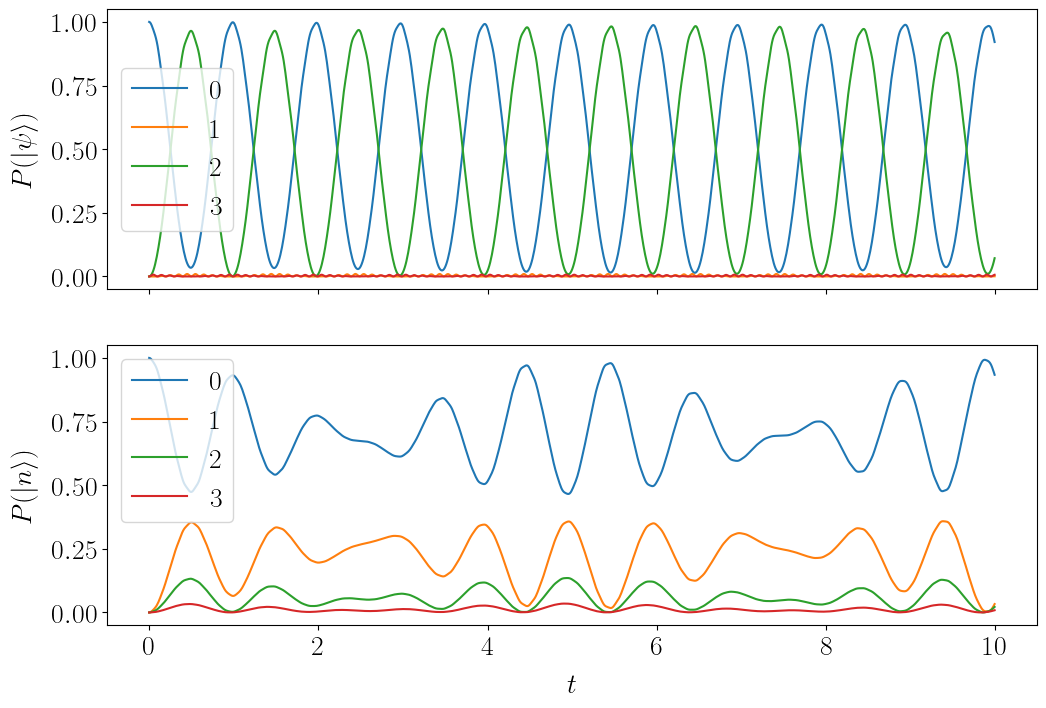

In [7]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(2, 1, sharex=True)

ax[0].plot(
    result["tspan"][k],
    [s.ptrace(0).diag()[:4] for s in result["states"][k]],
    label=range(4),
)

ax[1].plot(
    result["tspan"][k],
    [s.ptrace(1).diag()[:4] for s in result["states"][k]],
    label=range(4),
)


ax[1].set_xlabel(r"$t$", labelpad=10)
ax[0].set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)
ax[1].set_ylabel(r"$P(| n \rangle)$", labelpad=10)

ax[0].legend()
ax[1].legend()

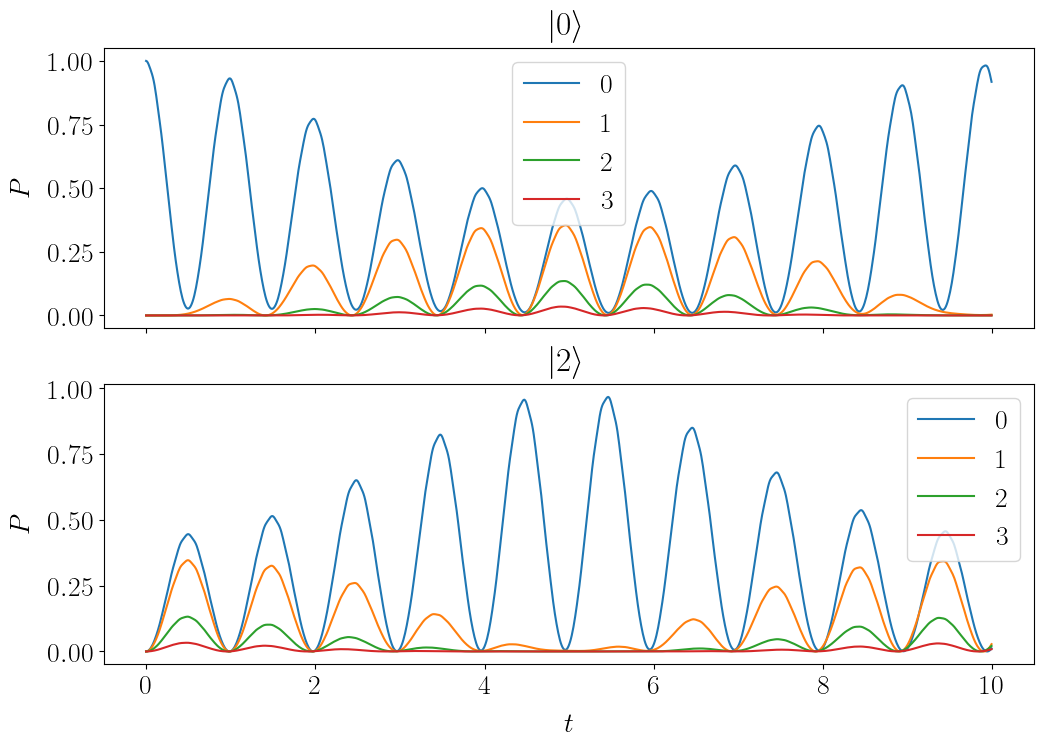

In [8]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(2, 1, sharex=True)

ax[0].set_title(r"$| 0 \rangle$", pad=10)
ax[1].set_title(r"$| 2 \rangle$", pad=10)

ax[0].plot(
    result["tspan"][k],
    [qt.ket2dm(s).diag()[:4] for s in result["states"][k]],
    label=range(4),
)

ax[1].plot(
    result["tspan"][k],
    [qt.ket2dm(s).diag()[20:24] for s in result["states"][k]],
    label=range(4),
)

ax[1].set_xlabel(r"$t$", labelpad=10)
ax[0].set_ylabel(r"$P$", labelpad=10)
ax[1].set_ylabel(r"$P$", labelpad=10)

ax[0].legend()
ax[1].legend()